#Different Tensorflow Constant and variables tensors



In [2]:
#All ones or all-zeros tensor

import tensorflow as tf

x = tf.ones(shape=(2,1))
print(x)

x = tf.zeros(shape=(2,1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


In [5]:
#Random Tensors

x = tf.random.normal(shape=(3,1), mean=0., stddev=1.)
print(x)

x = tf.random.uniform(shape=(3,1),minval=0.,maxval=1.)
print(x)

tf.Tensor(
[[-1.5086038]
 [ 1.5889875]
 [ 0.5364072]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[0.02399814]
 [0.40427005]
 [0.0104481 ]], shape=(3, 1), dtype=float32)


Difference between numpy and tensorflow tensors is that TF tensors aren't assignable: they're constant.

In [6]:
import numpy as np

x = np.ones(shape=(2,2))
x[0,0]=0
print(x)

[[0. 1.]
 [1. 1.]]


In [11]:
#Create Tensorflow variable

v = tf.Variable(initial_value=tf.random.normal(shape=(3,1)))
print(v)

#Variable state can be modified via "assign" method

v.assign(tf.ones((3,1)))
print(v)
#Also for subset of coefficients

v[0,0].assign(3.)
print(v)

#"assign_add()" and "assign_sub()" are equivalents of "+=" and "-="

v.assign_add(tf.ones((3,1)))
print(v)

v.assign_sub(tf.ones((3,1)))

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.06483275],
       [ 0.8133903 ],
       [ 0.49384072]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>


<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

##Math in tensorflow

In [12]:
a = tf.ones((2,2))
b = tf.square(a)
c = tf.sqrt(a)
d = b+c
e = tf.matmul(a,b)
e *= d

#GradientTape

Numpy can't retrieve differentiable expression with respect to any of its inputs.
Use GradientTape scope, apply some computation to one or several input tensors, retrieve gradient of the result with respect to the inputs.

In [13]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
  result = tf.square(input_var)
gradient = tape.gradient(result, input_var)

Most commonly used to retrieve the gradients of th eloss of a model wrt its weights "gradients = tape.Gradient(loss,weights)".
Possible for the inputs to be any arbitrary tensor, only trainable variables are tracked by default tho.
With a constant tensor we have to mark it manually by calling "tape.watch()" on it.

In [15]:
#GradientTape with constant tensor input

input_const = tf.constant(3.)
with tf.GradientTape() as tape:
  tape.watch(input_const)
  result = tf.square(input_const)
gradient = tape.gradient(result,input_const)

Necessary because would be too expensive to preemptively store the information required to compute the gradient of anything wrt anything.
To avoid wasting resources, tape needs to know what to watch.
Trainable variables are watched by default because computing the gradient of a loss is the most common use of a gradient tape.

Gradient tape is capable of computing second-order gradients, the gradient of a gradient.

In [17]:
#Nested gradient tapes to compute second-order gradients

time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as inner_tape:
    position = 4.9 * time ** 2
  speed = inner_tape.gradient(position,time)
acceleration = outer_tape.gradient(speed, time)

#End-To-end example: Linear Classifier in pure Tensorflow

In [18]:
#Generate two classes of random points in 2D plane

num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(mean=[0,3], cov=[[1,0.5],[0.5,1]],size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(mean=[3,0],cov=[[1,0.5],[0.5,1]],size = num_samples_per_class)

Stack them into a single array with shape (2000,2).
Generate corresponding target labels, array of zeros and ones of shape (2000,1) where targets[i,0] is 0 if inputs[i] belongs to class 0

In [24]:
inputs = np.vstack((negative_samples,positive_samples)).astype(np.float32)

In [25]:
targets = np.vstack((np.zeros((num_samples_per_class,1),dtype='float32'),
                    np.ones((num_samples_per_class,1), dtype='float32')))

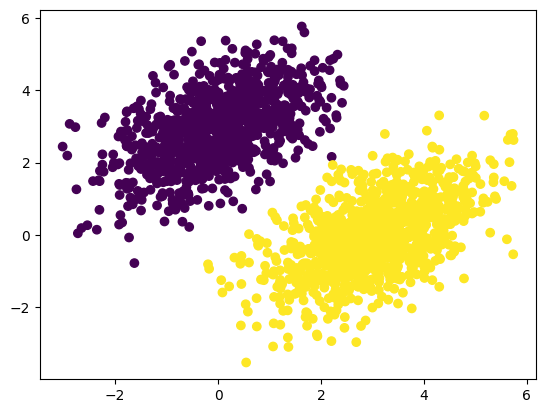

In [26]:
import matplotlib.pyplot as plt

plt.scatter(inputs[:,0], inputs[:,1], c=targets[:,0])
plt.show()

Let's create a linear classifier that can learn to separate the blobs.
A linear classifier is an affine transformation (prediction = W o input + b) trained to minimize the square of the difference between predictions and targets.

In [27]:
#Create the linear classifier variables

input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

In [28]:
#Forward pass function

def model(inputs):
  return tf.matmul(inputs,W)+b

In [29]:
#Loss function
def square_loss(targets, predictions):
  per_sample_losses = tf.square(targets-predictions)
  return tf.reduce_mean(per_sample_losses)

In [38]:
#Train step function

learning_rate = 0.1
def training_step(inputs,targets):
  with tf.GradientTape() as tape:
    predictions = model(inputs)
    loss = square_loss(predictions,targets)
  grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W,b])
  W.assign_sub(grad_loss_wrt_W*learning_rate)
  b.assign_sub(grad_loss_wrt_b*learning_rate)
  return loss

In [39]:
#Batch Training (all the data)

for step in range(40):
  loss = training_step(inputs, targets)
  print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 0.0965
Loss at step 1: 0.0899
Loss at step 2: 0.0838
Loss at step 3: 0.0784
Loss at step 4: 0.0734
Loss at step 5: 0.0689
Loss at step 6: 0.0648
Loss at step 7: 0.0611
Loss at step 8: 0.0577
Loss at step 9: 0.0546
Loss at step 10: 0.0518
Loss at step 11: 0.0493
Loss at step 12: 0.0469
Loss at step 13: 0.0448
Loss at step 14: 0.0429
Loss at step 15: 0.0412
Loss at step 16: 0.0396
Loss at step 17: 0.0382
Loss at step 18: 0.0369
Loss at step 19: 0.0357
Loss at step 20: 0.0346
Loss at step 21: 0.0336
Loss at step 22: 0.0327
Loss at step 23: 0.0319
Loss at step 24: 0.0312
Loss at step 25: 0.0305
Loss at step 26: 0.0299
Loss at step 27: 0.0293
Loss at step 28: 0.0288
Loss at step 29: 0.0284
Loss at step 30: 0.0279
Loss at step 31: 0.0276
Loss at step 32: 0.0272
Loss at step 33: 0.0269
Loss at step 34: 0.0266
Loss at step 35: 0.0264
Loss at step 36: 0.0261
Loss at step 37: 0.0259
Loss at step 38: 0.0257
Loss at step 39: 0.0255


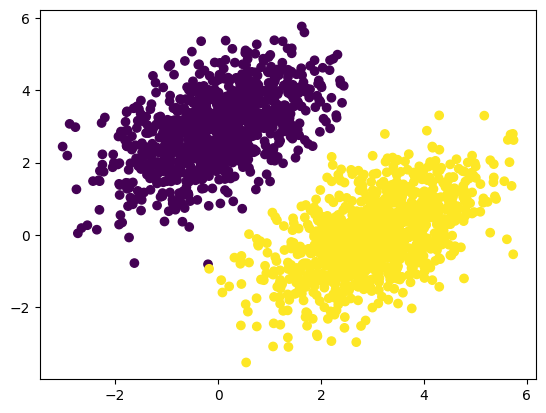

In [41]:
#Plot how the linear model classifies the training datapoints

predictions = model(inputs)
plt.scatter(inputs[:,0], inputs[:,1], c=predictions[:,0]>0.5)
plt.show()

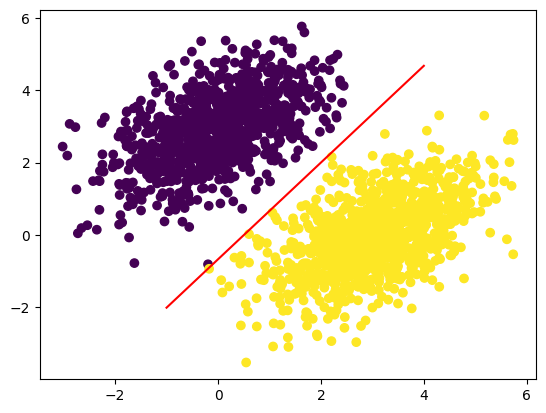

In [42]:
#Let's plot the line

x = np.linspace(-1,4,100)
y = - W[0] / W[1] * x + (0.5-b) /W[1]
plt.plot(x,y,"r")
plt.scatter(inputs[:,0], inputs[:,1], c=predictions[:,0]>0.5)

#Keras Layers

In [46]:
#Base keras layer

import keras

class SimpleDense(keras.layers.Layer):

  def __init__(self, units, activation=None):
    super().__init__()
    self.units = units
    self.activation = activation

  def build(self, input_shape):
    input_dim = input_shape[-1]
    self.W = self.add_weight(shape=(input_dim,self.units),initializer='random_normal')
    self.b = self.add_weight(shape=(self.units,), initializer='zeros')
  
  def call(self, inputs):
    y = tf.matmul(inputs,self.W)+self.b
    if self.activation is not None:
      y = self.activation(y)
    return y

In [47]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2,784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)
